## Simple Neural Network in PyTorch

In [52]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [53]:
from  torchvision import datasets
import torchvision.transforms as trnasforms

num_workers = 0
batch_size = 20

transform = trnasforms.ToTensor()

train_data = datasets.MNIST(root='data/raw',train=True,download=False, transform=transform)
test_data = datasets.MNIST(root='data',train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


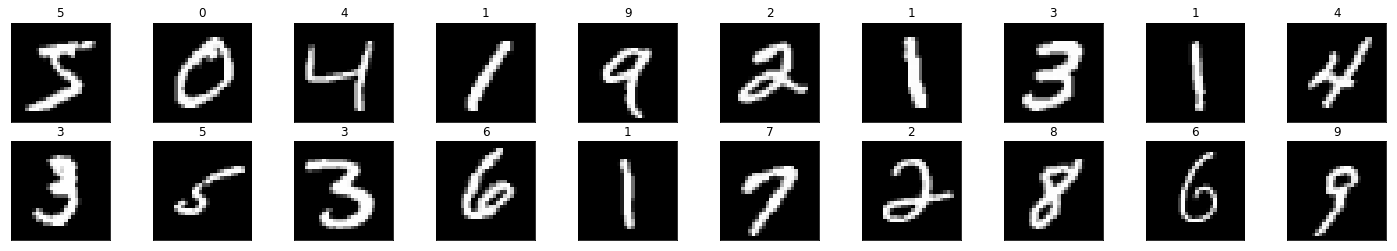

In [54]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title(str(labels[idx].item()))
plt.show()    

## Network

In [55]:
import torch.nn as nn
import torch.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = x.view(-1,784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.logsoftmax(self.fc3(x))
        return x
        
model = Net()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [56]:
from tqdm import tqdm
epochs = 5
train_loss = []
test_loss = []
for e in range(epochs):
    epoch_loss = 0
    model.train()
    for ii,(images, labels) in tqdm(enumerate(train_loader)):
        images = images.view(images.shape[0],-1)
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss
    train_loss.append(epoch_loss/ii)
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for ii,(images, labels) in enumerate(test_loader):
            images = images.view(images.shape[0],-1)
            output = model.forward(images)
            loss = criterion(output,labels)
            epoch_loss +=loss
        test_loss.append(epoch_loss/ii)    

3000it [00:50, 52.23it/s]
3000it [01:04, 46.67it/s]
3000it [01:16, 39.04it/s]
3000it [01:16, 39.24it/s]
3000it [01:16, 38.97it/s]


Network is overfitting

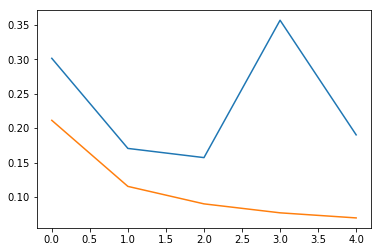

In [57]:
plt.plot(test_loss)
plt.plot(train_loss)
plt.show()

## Changed Network to avoid Overfitting

In [4]:
import torch.nn as nn
import torch.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
        
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = x.view(-1,784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.logsoftmax(self.fc3(x))
        return x
        
model = Net()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [5]:
from tqdm import tqdm
epochs = 5
train_loss = []
test_loss = []
for e in range(epochs):
    model.train()
    epoch_loss = 0
    for ii,(images, labels) in tqdm(enumerate(train_loader)):
        images = images.view(images.shape[0],-1)
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss
    train_loss.append(epoch_loss/ii)
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for ii,(images, labels) in enumerate(test_loader):
            images = images.view(images.shape[0],-1)
            output = model.forward(images)
            loss = criterion(output,labels)
            epoch_loss +=loss
        test_loss.append(epoch_loss/ii)    
     

3000it [00:55, 50.41it/s]
3000it [01:05, 45.49it/s]
3000it [01:07, 44.90it/s]
3000it [01:10, 43.38it/s]
3000it [01:07, 44.48it/s]


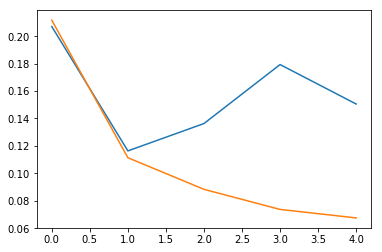

In [6]:
plt.plot(test_loss)
plt.plot(train_loss)
plt.show()

## Using Validation Set

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
valid_size = 0.2
batch_size = 20
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(train_idx)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data,sampler=train_sampler, batch_size=batch_size)
validation_loader= torch.utils.data.DataLoader(train_data,sampler=train_sampler, batch_size=batch_size)

In [22]:
from tqdm import tqdm
epochs = 5
train_loss = []
valid_loss = []
valid_loss_min = np.inf
# training
for e in range(epochs):
    model.train()
    epoch_loss = 0
    model.train()
    for ii,(images, labels) in tqdm(enumerate(train_loader)):
        images = images.view(images.shape[0],-1)
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss
    train_loss.append(epoch_loss/ii)
    # validation
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for ii,(images, labels) in enumerate(validation_loader):
            images = images.view(images.shape[0],-1)
            output = model.forward(images)
            loss = criterion(output,labels)
            epoch_loss +=loss
        valid_loss.append(epoch_loss/ii)
    # if validation loss is minimized, save the model    
    if epoch_loss/ii <= valid_loss_min:    
        print("validation loss decreased")
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = epoch_loss/ii
            
    
        

2400it [00:59, 40.61it/s]


validation loss decreased


2400it [00:55, 43.22it/s]


validation loss decreased


2400it [00:55, 42.16it/s]
2400it [00:58, 41.06it/s]


validation loss decreased


2400it [00:56, 42.17it/s]


validation loss decreased


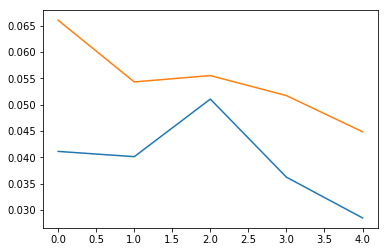

In [24]:
plt.plot(valid_loss)
plt.plot(train_loss)
plt.show()

In [25]:
model.load_state_dict(torch.load('model.pt'))

In [49]:
# Test set accuracy
model.eval()
accuracy = 0
with torch.no_grad():
    epoch_loss = 0
    for ii,(images, labels) in enumerate(test_loader):
        images = images.view(images.shape[0],-1)
        output = model.forward(images)
        acc = labels.numpy()==np.argmax(output.numpy(), axis=1)
        acc = np.mean(acc)
        accuracy +=(acc.astype('float'))
        epoch_loss +=loss
print("Test accuracy of the system:",accuracy/ii)

Test accuracy of the system: 0.976653306613
